In [78]:
import numpy as np
from random import randint
import matplotlib
import matplotlib.pyplot as plt
import time
import scipy.io
from PIL import Image
from IPython import display

# K-Means Clustering

## Part 1: Setting Up Functions

### Load Data

In [79]:
matrix = scipy.io.loadmat("ex7data2.mat")

In [80]:
# view headers
matrix.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X'])

In [81]:
X = matrix["X"]

### Find Closest Centroid

In [82]:
def find_closest_centroid(X, init_centroids):
    m = len(X)
    K = len(init_centroids)
    idx = np.zeros((m,1)).reshape(-1,1)
    
    # go over each example, find the closest centroid
    for i in range(m):
        dists = np.zeros((K,2)) # store squared distances
        dists[:, 1] = [j for j in range(1,K+1)] # assign K values
        
        # get squared distance for each example
        for j in range(K):
            dists[j, 0] = np.sum((X[i, :] - init_centroids[j, :])**2, axis=0)
            
        # find closest centroid for each example
        # add centroid index to idx
        centroid_idx = np.where(dists == np.amin(dists[:, 0], axis=0))
        idx[i] = centroid_idx[0][0]
    
    return idx

In [83]:
K = 3
init_centroids = np.array([[3,3],[6,2],[8,5]])
closest_centroids = find_closest_centroid(X, init_centroids)

In [84]:
# check results
# first 3 centroids should be [0,2,1]
print(closest_centroids[:3])

[[0.]
 [2.]
 [1.]]


### Compute Centroid Means

In [85]:
def compute_centroids(X, idx, K):
    m = X.shape[0]
    n = X.shape[1]
    
    centroids = np.zeros((K, n))
    
    for i in range(K):
        num_examples = sum(idx == i)
        
        # add up all examples in the centroid
        for j in range(m):
            if idx[j] == i:
                centroids[i, :] = centroids[i, :] + X[j, :]
            
        # divide by num_examples to get mean for that centroid
        centroids[i, :] = centroids[i, :] / num_examples
    
    return centroids

In [86]:
centroids = compute_centroids(X, closest_centroids, K)

In [87]:
# check work
"""
[2.428301 3.15792],
[5.813503 2.63366],
[7.119387 3.61668]
"""
print(centroids)

[[2.42830111 3.15792418]
 [5.81350331 2.63365645]
 [7.11938687 3.6166844 ]]


### Run K-Means

In [88]:
def plot_kmeans(X, K, idx):
    colors = ['r', 'b']
    idx = idx.flatten()
    plt.scatter(X[:, 0], X[:, 1], c = idx, cmap=matplotlib.colors.ListedColormap(colors[:K]))
    plt.show()

In [89]:
def run_kmeans(X, init_centroids, max_iter, to_plot):
    # initialize values
    m = X.shape[0]
    n = X.shape[1]
    K = len(init_centroids)
    centroids = init_centroids
    #previous_centroids = centroids
    idx = np.zeros((m,1)).reshape(-1,1)
    
    # run k-means
    for i in range(max_iter):
        idx = find_closest_centroid(X, centroids)
        centroids = compute_centroids(X, idx, K)
        
        # update plot to show progress
        if to_plot:
            display.clear_output(wait=True)
            plot_kmeans(X, K, idx) 
            time.sleep(0.2)
        
        print("Iteration %d/%d complete" % (i+1, max_iter))
        
    
    return centroids, idx

In [90]:
max_iter = 10
K = 3
init_centroids = np.array([[3,3],[6,2],[8,5]])

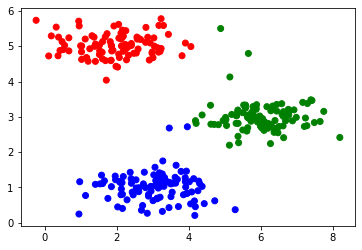

Iteration 10/10 complete


In [91]:
centroids, idx = run_kmeans(X, init_centroids, max_iter, True)

### Random Centroid Initialization

In [92]:
def kmeans_init_centroids(X, K):
    centroids = np.zeros((K, X.shape[1]))
    
    for i in range(K):
        centroids[i, :] = X[randint(0,len(X)), :]
    
    return centroids

In [93]:
init_centroids = kmeans_init_centroids(X, K)

## Part 2: Image Compression with K-Means

### Loading Image to Array

In [128]:
def load_image(filename):
    img = Image.open(filename)
    img.load()
    data = np.asarray(img, dtype='int32') # convert to array
    return data, img

In [129]:
# get image array
img_name = "bird_small.png"
img_arr, img_orig = load_image(img_name)

In [130]:
# array dim
img_arr.shape # 128x128x3

(128, 128, 3)

### Reshape Matrix

In [131]:
img_arr = img_arr / 255 # make all values between 0-1

In [132]:
X = img_arr.reshape(img_arr.shape[0]*img_arr.shape[1], 3)

### K-Means to Find Top 16 Colors

In [133]:
K = 8
max_iter = 10
init_centroids = kmeans_init_centroids(X, K)

In [134]:
centroids, idx = run_kmeans(X, init_centroids, max_iter, False)

Iteration 1/10 complete
Iteration 2/10 complete
Iteration 3/10 complete
Iteration 4/10 complete
Iteration 5/10 complete
Iteration 6/10 complete
Iteration 7/10 complete
Iteration 8/10 complete
Iteration 9/10 complete
Iteration 10/10 complete


In [135]:
new_colors = centroids*255
new_colors = new_colors.round(0)

In [136]:
new_colors

array([[153., 147., 153.],
       [239., 224., 190.],
       [ 19.,  21.,  18.],
       [ 31.,  33.,  31.],
       [164., 123.,  69.],
       [216., 173., 107.],
       [103.,  85.,  75.],
       [ 56.,  53.,  51.]])

### Create Compressed Image

In [137]:
def compress_img(X, idx, img_arr, new_colors):
    # assign new colors to each pixel
    X_compress = X
    for i in range(len(idx)):
        new_pixel = new_colors[int(idx[i])]
        X_compress[i] = new_pixel
        
    # reshape arry
    X_compress = X_compress.reshape(img_arr.shape[0], img_arr.shape[1], X_compress.shape[1])
    
    # array to img
    img_compressed = Image.fromarray(X_compress.astype('uint8'), 'RGB')
    
    return img_compressed

In [138]:
img_compressed = compress_img(X, idx, img_arr, new_colors)

Text(0.5, 0, 'Compressed')

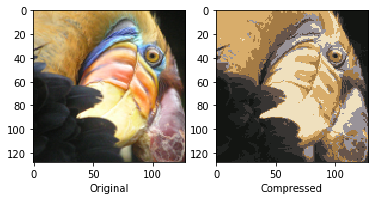

In [140]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(np.asarray(img_orig))
ax[1].imshow(np.asarray(img_compressed))

ax[0].set_xlabel("Original")
ax[1].set_xlabel("Compressed")

## Part 3: Use Own Image

### Load and Create Array

In [108]:
# get image array
img_name = "ex7_part3.jpg"
img_arr, img_orig = load_image(img_name)

In [109]:
img_arr = img_arr / 255 # make all values between 0-1

In [110]:
# reshape for algorithm 
X = img_arr.reshape(img_arr.shape[0]*img_arr.shape[1], 3)

### Implement K-Means

In [111]:
# initialize parameters
K = 16
max_iter = 10
init_centroids = kmeans_init_centroids(X, K)

In [112]:
# get centroids
centroids, idx = run_kmeans(X, init_centroids, max_iter, False)

Iteration 1/10 complete
Iteration 2/10 complete
Iteration 3/10 complete
Iteration 4/10 complete
Iteration 5/10 complete
Iteration 6/10 complete
Iteration 7/10 complete
Iteration 8/10 complete
Iteration 9/10 complete
Iteration 10/10 complete


In [113]:
# create new colors
new_colors = centroids*255
new_colors = new_colors.round(0)

In [114]:
# compress image
img_compressed = compress_img(X, idx, img_arr, new_colors)

Text(0.5, 0, 'Compressed')

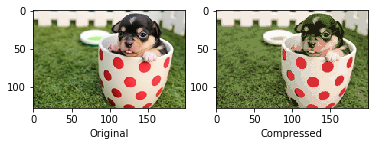

In [115]:
# display results
fig, ax = plt.subplots(1,2)
ax[0].imshow(np.asarray(img_orig))
ax[1].imshow(np.asarray(img_compressed))

ax[0].set_xlabel("Original")
ax[1].set_xlabel("Compressed")